In [1]:
!pip install yfinance pandas numpy matplotlib hmmlearn scipy


In [2]:
pip install --upgrade pip


   ---------------------------------------- 1.8/1.8 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM

# Parameters
TICKER = "SPY"      # choose: AAPL, TSLA, SPY, ^NSEI, etc.
PERIOD = "10y"
INTERVAL = "1d"
N_STATES = 2
RANDOM_STATE = 42


In [4]:
df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)

# Yahoo now auto-adjusts prices, so use "Close"
df = df[["Close"]].rename(columns={"Close": "Adj_Close"})
df.head()



C:\Users\ommun\AppData\Local\Temp\ipykernel_17128\2733750088.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
[*********************100%***********************]  1 of 1 completed


Price,Adj_Close
Ticker,SPY
Date,
2015-11-23,176.667053
2015-11-24,176.903595
2015-11-25,176.878250
2015-11-27,177.081055
2015-11-30,176.345917


In [5]:
df["LogReturn"] = np.log(df["Adj_Close"]).diff()
df = df.dropna()
df.head()


Price,Adj_Close,LogReturn
Ticker,SPY,
Date,,
2015-11-24,176.903595,0.001338
2015-11-25,176.878250,-0.000143
2015-11-27,177.081055,0.001146
2015-11-30,176.345917,-0.004160
2015-12-01,178.027481,0.009490


In [6]:
X = df["LogReturn"].values.reshape(-1, 1)

model = GaussianHMM(
    n_components=N_STATES,
    covariance_type="diag",
    n_iter=200,
    random_state=RANDOM_STATE
)

model.fit(X)

states = model.predict(X)
logprob, posteriors = model.score_samples(X)

print("Means:", model.means_.ravel())
print("Variances:", model.covars_.ravel())
print("\nTransition Matrix:")
print(model.transmat_)


Means: [ 0.00113233 -0.00138763]
Variances: [4.87351141e-05 4.13183182e-04]

Transition Matrix:
[[0.98494949 0.01505051]
 [0.047048   0.952952  ]]


In [7]:
df["State"] = states
df.tail()


Price,Adj_Close,LogReturn,State
Ticker,SPY,,
Date,,,
2025-11-17,665.669983,-0.009360,0
2025-11-18,660.080017,-0.008433,0
2025-11-19,662.630005,0.003856,0
2025-11-20,652.530029,-0.015360,0
2025-11-21,659.030029,0.009912,0


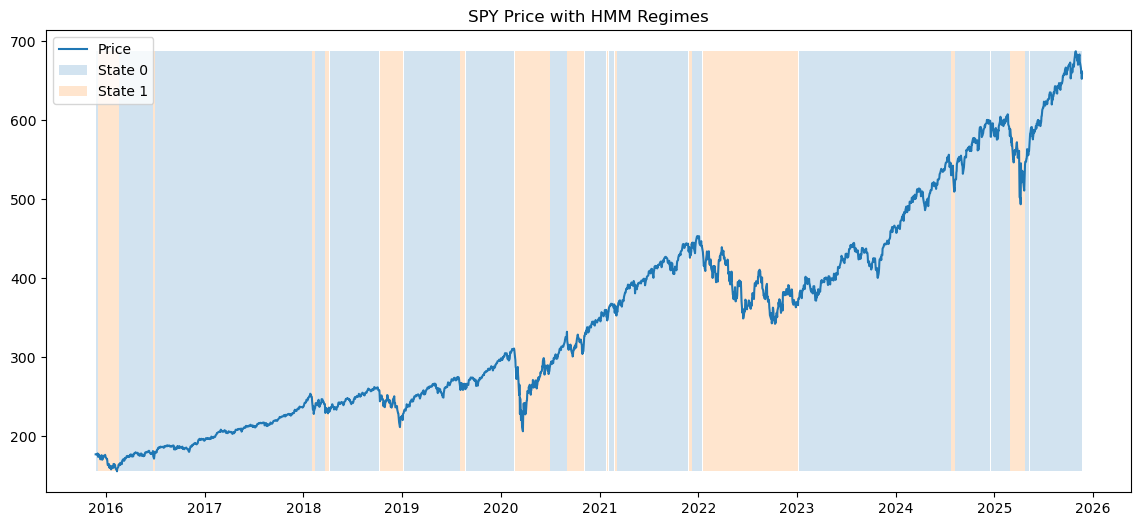

In [8]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Adj_Close"], label="Price")

for s in range(N_STATES):
    mask = df["State"] == s
    plt.fill_between(df.index, df["Adj_Close"].min(), df["Adj_Close"].max(),
                     where=mask, alpha=0.2, label=f"State {s}")

plt.title(f"{TICKER} Price with HMM Regimes")
plt.legend()
plt.show()


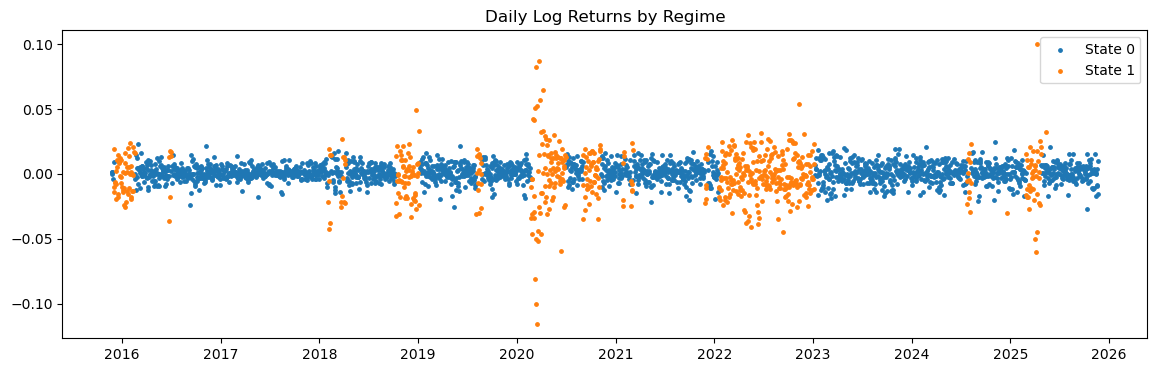

In [9]:
plt.figure(figsize=(14,4))

for s in range(N_STATES):
    idx = df["State"] == s
    plt.scatter(df.index[idx], df["LogReturn"][idx], s=6, label=f"State {s}")

plt.title("Daily Log Returns by Regime")
plt.legend()
plt.show()


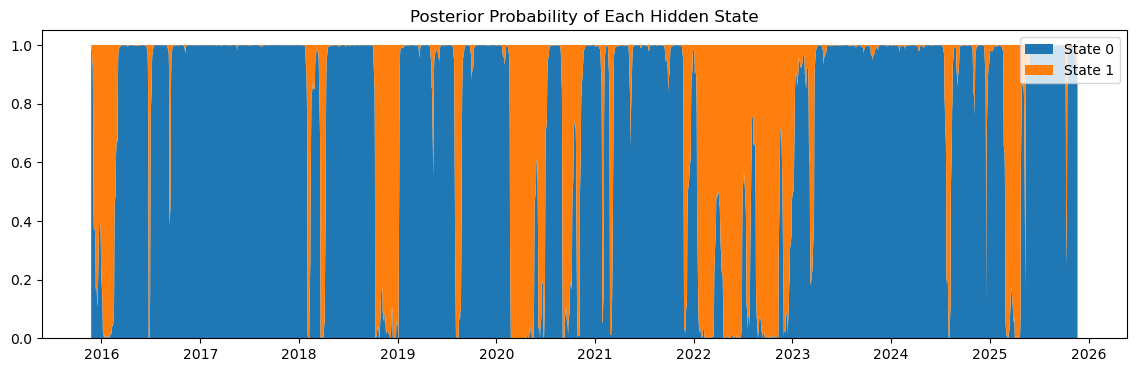

In [10]:
plt.figure(figsize=(14,4))
plt.stackplot(df.index, posteriors.T, labels=[f"State {i}" for i in range(N_STATES)])

plt.title("Posterior Probability of Each Hidden State")
plt.legend()
plt.show()


In [11]:
last_post = posteriors[-1]
next_state_prob = last_post @ model.transmat_

print("Next day state probabilities:")
for i, p in enumerate(next_state_prob):
    print(f"State {i}: {p:.4f}")

print("\nMost likely next state:", np.argmax(next_state_prob))


Next day state probabilities:
State 0: 0.8705
State 1: 0.1295

Most likely next state: 0


In [12]:
df.to_csv(f"{TICKER}_HMM_states.csv")
df.head()
print(f"Saved as {TICKER}_HMM_states.csv")


Saved as SPY_HMM_states.csv
